In [1]:
import pandas as pd
import numpy as np
import gc
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import MinMaxScaler


from myutils import reduce_mem_usage

lentrain = 1503424
lentest = 508438
lentrainactive = 14129821
lentestactive = 12824068

categorical = []

In [2]:
def scale_standard(df, ignorecol=[]):
    cols = deepcopy(df.columns)
    for col in cols:
        #print(col)
        if (str(df[col].dtype)[:5] == 'float') and (not col in ignorecol):
            temp = SS().fit_transform(df[col].values.ravel().reshape(-1, 1))
            df[col] = temp.flatten()
    return df

def get_smalldiff(df1, df2, userate=0.2):
    assert (df1.columns == df2.columns).all(), 'inputs must have same columns'
    th = np.uint(df1.shape[1] * userate)
    criteria = {'mean': np.mean, 'var': np.var, 'median': np.median}
    difflist = []
    tempdiff = pd.DataFrame()
    tempdiff['colname'] = [col for col in df1.columns]
    for k, c in criteria.items():
        tempdiff[k] = [np.abs(c(df1[col]) - c(df2[col])) for col in df1.columns]
    tempdiff = scale_standard(tempdiff, ignorecol=['colname'])
    sums = np.zeros(tempdiff.shape[0])
    for key in criteria.keys():
        sums += np.abs(tempdiff[key])
    tempdiff['result'] = sums
    sortdiff = tempdiff.sort_values(by='result')
    print(sortdiff[['colname', 'result']])
    return sortdiff['colname'][: th].tolist()

def loadfeather(trpath, tepath, reader=pd.read_feather):
    train = reader(trpath)
    test = reader(tepath)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)    
    df = pd.concat([train, test])
    del train, test; gc.collect()
    print(df.nunique())
    return df

def plothist(df):
    sidesplit = 3
    versplit = len(df.columns)//sidesplit + 1
    width = 4*sidesplit
    height = 3*versplit
    plt.figure(figsize=(width, height))
    for i, col in enumerate(df.columns):
        plt.subplot(versplit, sidesplit, i+1)
        plt.hist(df.iloc[:, i], label=col) 
        plt.legend()
    plt.show()

def plotcorr(df):
    colsize = len(df.columns)
    width = 6 + np.uint(colsize*0.2)
    height = 4 + np.uint(colsize*0.2)
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.set(style='white')
    f, ax = plt.subplots(figsize=(width, height))
    cmap = sns.diverging_palette(30, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
def concat2master(df, dfmaster):
    print(df.shape)
    #print(df.isnull().sum())
    df = reduce_mem_usage(df)
    #print(df.columns)
    #print(df.dtypes)
    for col in df.columns:
        dfmaster[col] = df[col]
    del df; gc.collect()
    print(dfmaster.shape)
    print(dfmaster.memory_usage().sum() / 1024**2, ' MB')
    return dfmaster

def scale_minmax(df, ignorecol=[]):
    cols = deepcopy(df.columns)
    for col in cols:
        if (str(df[col].dtype)[:3] == 'int') or (str(df[col].dtype)[:4] == 'uint'):
            print(col)
            temp = MinMaxScaler().fit_transform(df[col].values.ravel().reshape(-1, 1))
            df[col] = temp.flatten()
    return df

def choose_unique(df):
    print(f'before: {len(df.columns)}')
    uniques = {col: df[col].nunique() for col in df.columns}
    uniques_list = []
    for val in set(uniques.values()):
        temp = [k for k, v in uniques.items() if v == val]
        uniques_list.append(temp)
    uniques_list
    choiced = [str(np.random.choice(l, 1)[0]) for l in uniques_list]
    print(f'after: {len(choiced)}')
    return choiced

In [3]:
dfmaster = pd.DataFrame()

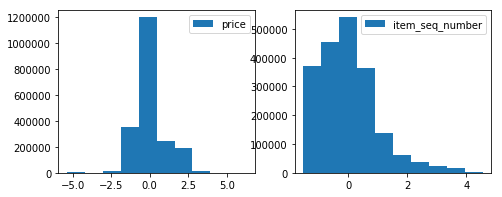

(2011862, 2)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 30.70 MB
Decreased by 0.0%
(2011862, 2)
30.698577880859375  MB


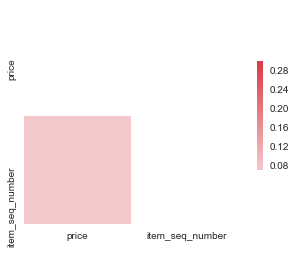

In [4]:
# Raw Numeric Features
nume_dtypes = {'price': 'float32', 'item_seq_number': 'float32'}
train = pd.read_csv('../input/train.csv', usecols=['price', 'item_seq_number'], dtype=nume_dtypes)
test = pd.read_csv('../input/test.csv', usecols=['price', 'item_seq_number'], dtype=nume_dtypes)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
df = pd.concat([train, test])
del train, test; gc.collect()

df['price'] = np.log(df['price']+0.001)
df['price'].fillna(df['price'].mean(), inplace=True)
df['item_seq_number'] = np.log1p(df['item_seq_number'])

df = scale_standard(df)
plothist(df)
plotcorr(df)

dfmaster = concat2master(df, dfmaster)

user_id                 1009909
region                       28
city                       1752
parent_category_name          9
category_name                47
param_1                     372
param_2                     278
param_3                    1277
user_type                     3
param_123                  2402
weekofday                     7
dtype: int64


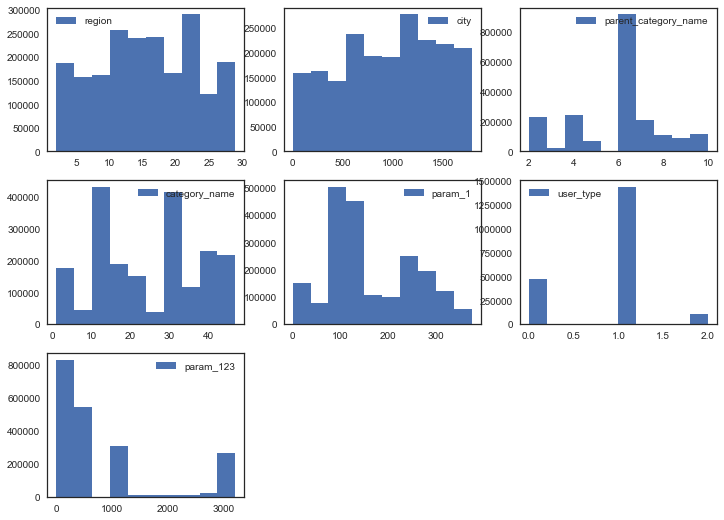

                colname    result
1                  city  0.878611
4               param_1  1.288921
3         category_name  1.552010
2  parent_category_name  1.557248
5             user_type  1.559326
0                region  1.744791
6             param_123  7.011978
(2011862, 7)
Memory usage of dataframe is 34.54 MB
Memory usage after optimization is: 34.54 MB
Decreased by 0.0%
(2011862, 9)
49.885189056396484  MB


In [5]:
# Categorical Features
df = loadfeather('../features/train/categorical_features_train.feather', '../features/test/categorical_features_test.feather')
df.drop(['user_id', 'param_2', 'param_3', 'weekofday'], axis=1, inplace=True)
plothist(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
categorical += df.columns.tolist()

tfidf_td_counttp_ridge    1923497
dtype: int64


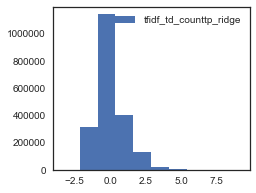

                  colname  result
0  tfidf_td_counttp_ridge     0.0
(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 10)
57.55983352661133  MB


"\ndf = loadfeather('../features/train/tfidf_td_counttp_tsvd_train.feather', '../features/test/tfidf_td_counttp_tsvd_test.feather')\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [6]:
# TFIDF Features
df = loadfeather('../features/train/tfidf_td_counttp_ridge_train.feather', '../features/test/tfidf_td_counttp_ridge_test.feather')
df = scale_standard(df)
plothist(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)

'''
df = loadfeather('../features/train/tfidf_td_counttp_tsvd_train.feather', '../features/test/tfidf_td_counttp_tsvd_test.feather')
df = scale_standard(df)
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

avg_days_up_user         17413
avg_times_up_user         7204
avg_headdays_up_user     29551
n_user_items               956
avg_price_up_user       161337
var_price_up_user       309985
dtype: int64


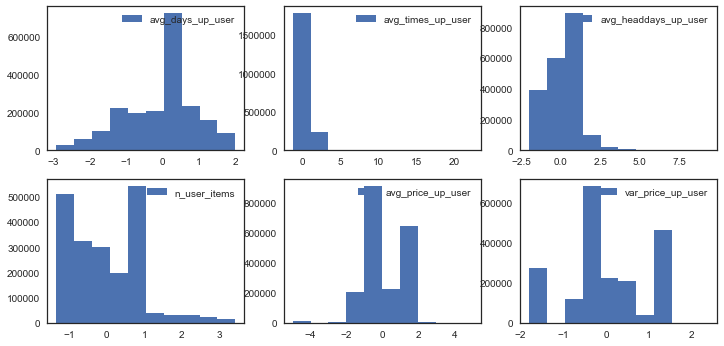

                colname    result
4     avg_price_up_user  2.157388
3          n_user_items  2.369647
1     avg_times_up_user  2.633943
0      avg_days_up_user  2.708459
5     var_price_up_user  2.797616
2  avg_headdays_up_user  4.140698
(2011862, 6)
Memory usage of dataframe is 61.40 MB
Memory usage after optimization is: 61.40 MB
Decreased by 0.0%
(2011862, 16)
103.60770034790039  MB


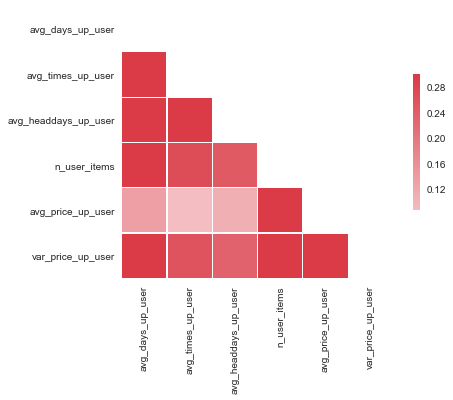

In [7]:
# User Data Agg
df = loadfeather('../features/train/Agg_User_train.feather', '../features/test/Agg_User_test.feather')
df['n_user_items'] = np.log1p(df['n_user_items'])
df['avg_price_up_user'] = np.log(df['avg_price_up_user']+0.001)
df['var_price_up_user'] = np.log(df['var_price_up_user']+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)


title_titleword_count                   15
title_upper_case_word_count             15
title_num_stopwords                     10
title_num_punctuations                  19
title_num_alphabets                      1
title_num_digits                         1
title_num_chars                         51
title_num_words                         17
title_num_unique_words                  15
title_chars_by_words                   285
title_words_by_uniquewords              42
title_punctuations_by_chars            260
title_punctuations_by_words            109
title_digits_by_chars                    1
title_alphabets_by_chars                 1
title_stopwords_by_words                49
title_mean                             282
description_titleword_count            226
description_upper_case_word_count      212
description_num_stopwords              151
description_num_punctuations           739
description_num_alphabets                2
description_num_digits                   1
description

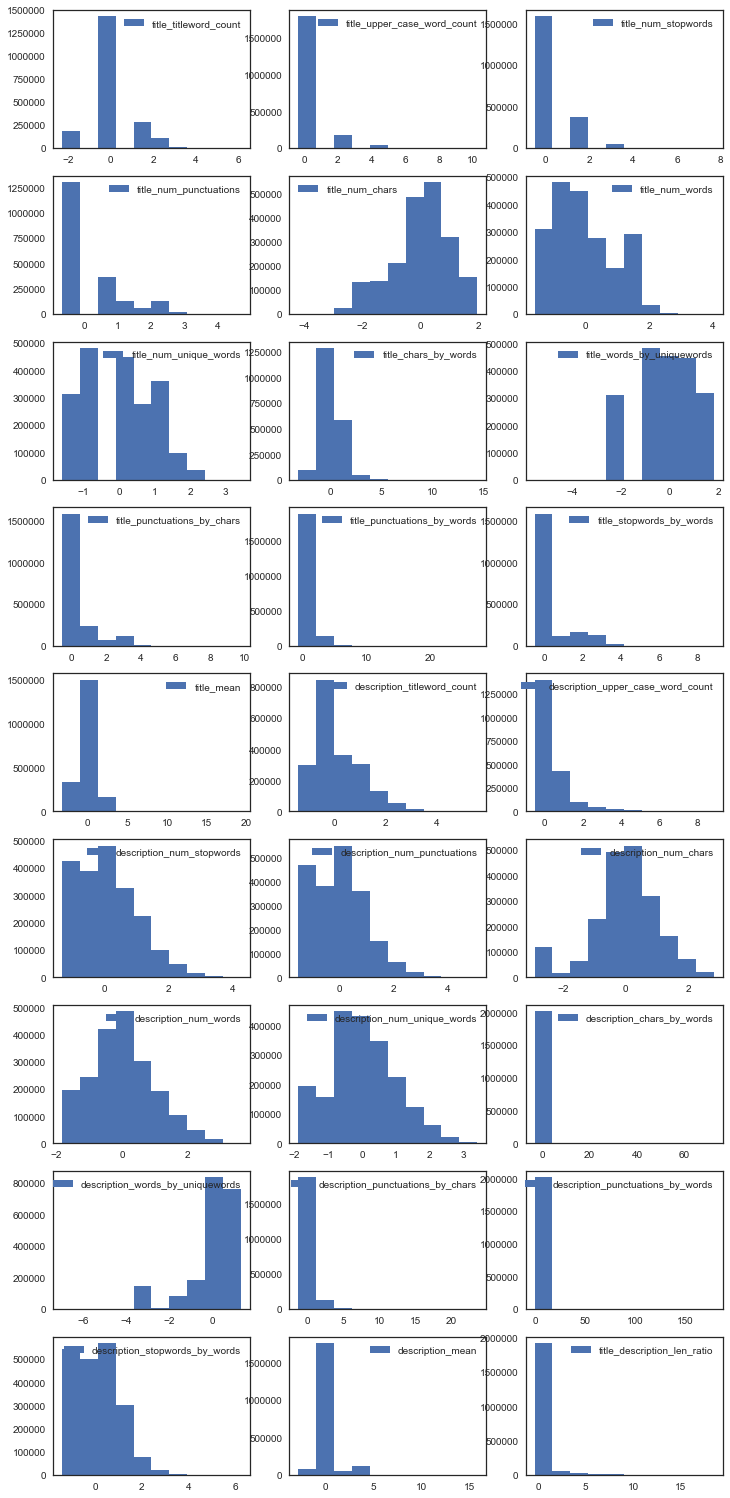

                              colname    result
22  description_punctuations_by_chars  1.185927
15          description_num_stopwords  1.251768
14  description_upper_case_word_count  1.328459
13        description_titleword_count  1.336173
23  description_punctuations_by_words  1.407820
19       description_num_unique_words  1.740240
1         title_upper_case_word_count  1.768018
8          title_words_by_uniquewords  1.957222
5                     title_num_words  1.987111
6              title_num_unique_words  1.987129
0               title_titleword_count  1.991918
4                     title_num_chars  2.006135
9         title_punctuations_by_chars  2.009514
3              title_num_punctuations  2.081599
12                         title_mean  2.106978
11           title_stopwords_by_words  2.115404
7                title_chars_by_words  2.167480
2                 title_num_stopwords  2.175166
10        title_punctuations_by_words  2.207745
17              description_num_chars  2

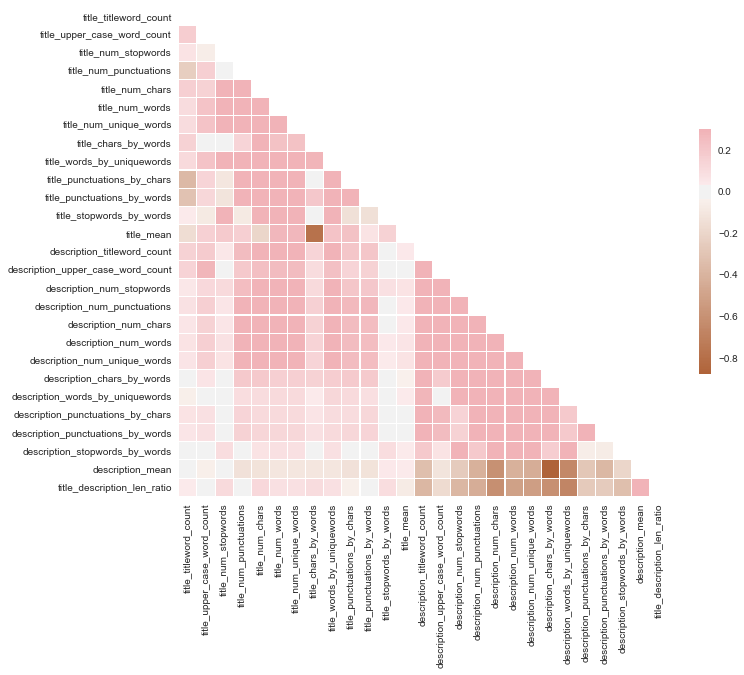

In [8]:
# Text features
df = loadfeather('../features/train/textfeatures_train.feather', '../features/test/textfeatures_test.feather')
for col in df.columns:
    col_spl = col.split('_')
    #print(col, df[col].min(), df[col].max())
    if col_spl[-1] == 'count' or col_spl[-2] == 'num' or col.count('num_unique_words'):
        df[col] = np.log1p(df[col])
        df[col] = df[col].astype('float32')

# 意味のないcolは落とす
droplist = ['title_num_alphabets', 'title_num_digits', 'description_num_digits', 'description_num_alphabets',
            'title_digits_by_chars', 'title_alphabets_by_chars', 'description_digits_by_chars', 'description_alphabets_by_chars']
df = df.drop(droplist, axis=1)
df = scale_standard(df)

plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)


In [9]:
# Count Agg
'''
df = loadfeather('../features/train/Agg_count_Golden_features_train.feather', '../features/test/Agg_count_Golden_features_test.feather')
for col in df.columns:
    df[col] = np.log1p(df[col])
df = scale_standard(df)
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_count_Golden_features_train.feather', '../features/test/Agg_count_Golden_features_test.feather')\nfor col in df.columns:\n    df[col] = np.log1p(df[col])\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [10]:
# Count Agg
'''
df = loadfeather('../features/train/Agg_Count_Silver_train.feather', '../features/test/Agg_Count_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Count_Silver_train.feather', '../features/test/Agg_Count_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [11]:
# Agg Price mean
'''
df = loadfeather('../features/train/Agg_Price_mean_Golden_features_train.feather', '../features/test/Agg_Price_mean_Golden_features_test.feather')
usecol = choose_unique(df)
df = df[usecol]
df = np.log(df+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_mean_Golden_features_train.feather', '../features/test/Agg_Price_mean_Golden_features_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\ndf = np.log(df+0.001)\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [12]:
# Agg Price var
'''
df = loadfeather('../features/train/Agg_Price_var_Golden_features_train.feather', '../features/test/Agg_Price_var_Golden_features_test.feather')
usecol = choose_unique(df)
df = df[usecol]
df = np.log(df+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_var_Golden_features_train.feather', '../features/test/Agg_Price_var_Golden_features_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\ndf = np.log(df+0.001)\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [13]:
# Agg Price median
'''
df = loadfeather('../features/train/Agg_Price_median_Golden_features_train.feather', '../features/test/Agg_Price_median_Golden_features_test.feather')
usecol = choose_unique(df)
df = df[usecol]
df = np.log(df+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_median_Golden_features_train.feather', '../features/test/Agg_Price_median_Golden_features_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\ndf = np.log(df+0.001)\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [14]:
# Agg Price Silver Mean
'''
df = loadfeather('../features/train/Agg_Price_mean_Silver_train.feather', '../features/test/Agg_Price_mean_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_mean_Silver_train.feather', '../features/test/Agg_Price_mean_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [15]:
# Agg Price Silver Var
'''
df = loadfeather('../features/train/Agg_Price_var_Silver_train.feather', '../features/test/Agg_Price_var_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_var_Silver_train.feather', '../features/test/Agg_Price_var_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [16]:
# Agg Price Silver Median
'''
df = loadfeather('../features/train/Agg_Price_median_Silver_train.feather', '../features/test/Agg_Price_median_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_median_Silver_train.feather', '../features/test/Agg_Price_median_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [17]:
# Agg Itemseq Mean
'''
df = loadfeather('../features/train/Agg_Itemseq_mean_Golden_features_train.feather', '../features/test/Agg_Itemseq_mean_Golden_features_test.feather')
usecol = choose_unique(df)
df = df[usecol]
df = np.log1p(df)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_mean_Golden_features_train.feather', '../features/test/Agg_Itemseq_mean_Golden_features_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\ndf = np.log1p(df)\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

In [18]:
# Agg Itemseq var
'''
df = loadfeather('../features/train/Agg_Itemseq_var_Golden_features_train.feather', '../features/test/Agg_Itemseq_var_Golden_features_test.feather')
usecol = choose_unique(df)
df = df[usecol]
df = np.log1p(df)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_var_Golden_features_train.feather', '../features/test/Agg_Itemseq_var_Golden_features_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\ndf = np.log1p(df)\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

In [19]:
# Agg Itemseq Median
'''
df = loadfeather('../features/train/Agg_Itemseq_median_Golden_features_train.feather', '../features/test/Agg_Itemseq_median_Golden_features_test.feather')
usecol = choose_unique(df)
df = df[usecol]
df = np.log1p(df)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_median_Golden_features_train.feather', '../features/test/Agg_Itemseq_median_Golden_features_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\ndf = np.log1p(df)\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

In [20]:
# Agg Item Silver mean
'''
df = loadfeather('../features/train/Agg_Itemseq_mean_Silver_train.feather', '../features/test/Agg_Itemseq_mean_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_mean_Silver_train.feather', '../features/test/Agg_Itemseq_mean_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [21]:
# Agg Itemseq Silver Var
'''
df = loadfeather('../features/train/Agg_Itemseq_var_Silver_train.feather', '../features/test/Agg_Itemseq_var_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_var_Silver_train.feather', '../features/test/Agg_Itemseq_var_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [22]:
# Agg Itemseq Silver Median
'''
df = loadfeather('../features/train/Agg_Itemseq_median_Silver_train.feather', '../features/test/Agg_Itemseq_median_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_median_Silver_train.feather', '../features/test/Agg_Itemseq_median_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [23]:
# Agg Nunique
'''
df = loadfeather('../features/train/Agg_numunique_Golden_features_train.feather', '../features/test/Agg_numunique_Golden_features_test.feather')
usecol = choose_unique(df)
df = df[usecol]
df = np.log1p(df)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_numunique_Golden_features_train.feather', '../features/test/Agg_numunique_Golden_features_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\ndf = np.log1p(df)\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

In [24]:
# Agg Nunique Silver
'''
df = loadfeather('../features/train/Agg_Unique_Silver_train.feather', '../features/test/Agg_Unique_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Unique_Silver_train.feather', '../features/test/Agg_Unique_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [25]:
# Create semi-Supervised data
'''
train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_semi.feather')
test.to_feather('../features/featured/test_semi.feather')

del train, test; gc.collect()
categorical
'''

"\ntrain = dfmaster[:lentrain]\ntest = dfmaster[lentrain: lentrain+lentest]\n\nprint(train.shape)\nprint(test.shape)\n\ntrain.to_feather('../features/featured/train_semi.feather')\ntest.to_feather('../features/featured/test_semi.feather')\n\ndel train, test; gc.collect()\ncategorical\n"

In [26]:
'''
# Wordbatch title
df = loadfeather('../features/train/wordbatch_title_ridge_train.feather', '../features/test/wordbatch_title_ridge_test.feather')
df = scale_standard(df)
plothist(df)
dfmaster = concat2master(df, dfmaster)

df = loadfeather('../features/train/wordbatch_title_tsvd_train.feather', '../features/test/wordbatch_title_tsvd_test.feather')
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\n# Wordbatch title\ndf = loadfeather('../features/train/wordbatch_title_ridge_train.feather', '../features/test/wordbatch_title_ridge_test.feather')\ndf = scale_standard(df)\nplothist(df)\ndfmaster = concat2master(df, dfmaster)\n\ndf = loadfeather('../features/train/wordbatch_title_tsvd_train.feather', '../features/test/wordbatch_title_tsvd_test.feather')\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

In [27]:
# Wordbatch description
'''
df = loadfeather('../features/train/wordbatch_description_ridge_train.feather', '../features/test/wordbatch_description_ridge_test.feather')
df = scale_standard(df)
plothist(df)
dfmaster = concat2master(df, dfmaster)

df = loadfeather('../features/train/wordbatch_description_tsvd_train.feather', '../features/test/wordbatch_description_tsvd_test.feather')
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/wordbatch_description_ridge_train.feather', '../features/test/wordbatch_description_ridge_test.feather')\ndf = scale_standard(df)\nplothist(df)\ndfmaster = concat2master(df, dfmaster)\n\ndf = loadfeather('../features/train/wordbatch_description_tsvd_train.feather', '../features/test/wordbatch_description_tsvd_test.feather')\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

In [28]:
# Wordbatch ensemble
'''
df = loadfeather('../features/train/wordbatch_ensemble_ridge_train.feather', '../features/test/wordbatch_ensemble_ridge_test.feather')
df = scale_standard(df)
plothist(df)
dfmaster = concat2master(df, dfmaster)

df = loadfeather('../features/train/wordbatch_ensemble_tsvd_train.feather', '../features/test/wordbatch_ensemble_tsvd_test.feather')
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/wordbatch_ensemble_ridge_train.feather', '../features/test/wordbatch_ensemble_ridge_test.feather')\ndf = scale_standard(df)\nplothist(df)\ndfmaster = concat2master(df, dfmaster)\n\ndf = loadfeather('../features/train/wordbatch_ensemble_tsvd_train.feather', '../features/test/wordbatch_ensemble_tsvd_test.feather')\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

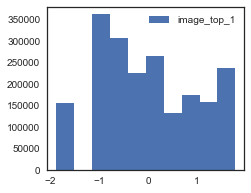

(2011862, 1)
Memory usage of dataframe is 23.02 MB
Memory usage after optimization is: 23.02 MB
Decreased by 0.0%
(2011862, 44)
318.497745513916  MB


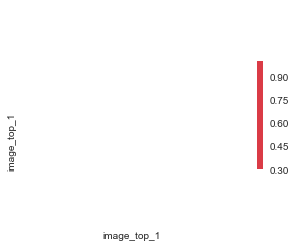

In [29]:
# Raw Numeric Features
nume_dtypes = {'image_top_1': 'float32'}
train = pd.read_csv('../input/train.csv', usecols=['image_top_1'], dtype=nume_dtypes)
test = pd.read_csv('../input/test.csv', usecols=['image_top_1'], dtype=nume_dtypes)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
df = pd.concat([train, test])
del train, test; gc.collect()

df['image_top_1'].fillna(-999, inplace=True)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

In [30]:
# Agg Imagetop Mean
'''
df = loadfeather('../features/train/Agg_Imagetop1_mean_Golden_features_train.feather', '../features/test/Agg_Imagetop1_mean_Golden_features_test.feather')
usecol = choose_unique(df)
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Imagetop1_mean_Golden_features_train.feather', '../features/test/Agg_Imagetop1_mean_Golden_features_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

In [31]:
# Agg Imagetop Var
'''
df = loadfeather('../features/train/Agg_Imagetop1_var_Golden_features_train.feather', '../features/test/Agg_Imagetop1_var_Golden_features_test.feather')
usecol = choose_unique(df)
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Imagetop1_var_Golden_features_train.feather', '../features/test/Agg_Imagetop1_var_Golden_features_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

In [32]:
# Agg Imagetop Median
'''
df = loadfeather('../features/train/Agg_Imagetop1_median_Golden_features_train.feather', '../features/test/Agg_Imagetop1_median_Golden_features_test.feather')
usecol = choose_unique(df)
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Imagetop1_median_Golden_features_train.feather', '../features/test/Agg_Imagetop1_median_Golden_features_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

In [33]:
# Agg Imagetop Mean
'''
df = loadfeather('../features/train/Agg_Imagetop1_mean_Silver_train.feather', '../features/test/Agg_Imagetop1_mean_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Imagetop1_mean_Silver_train.feather', '../features/test/Agg_Imagetop1_mean_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [34]:
# Agg Imagetop Var
'''
df = loadfeather('../features/train/Agg_Imagetop1_var_Silver_train.feather', '../features/test/Agg_Imagetop1_var_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Imagetop1_var_Silver_train.feather', '../features/test/Agg_Imagetop1_var_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [35]:
# Agg Imagetop Median
'''
df = loadfeather('../features/train/Agg_Imagetop1_median_Silver_train.feather', '../features/test/Agg_Imagetop1_median_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Imagetop1_median_Silver_train.feather', '../features/test/Agg_Imagetop1_median_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

imagefeatures__dullness                 20000
imagefeatures__whiteness                19999
imagefeatures__average_pixel_width     385129
imagefeatures__image_size               91662
imagefeatures__blurrness              1800693
imagefeatures__average_red            1728771
imagefeatures__average_green          1707081
imagefeatures__average_blue           1702035
imagefeatures__width                      609
imagefeatures__height                     452
dtype: int64
imagefeatures__image_size
imagefeatures__width
imagefeatures__height


C:\Users\ahega\Anaconda3\envs\Avito18_Kaggle\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ahega\Anaconda3\envs\Avito18_Kaggle\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


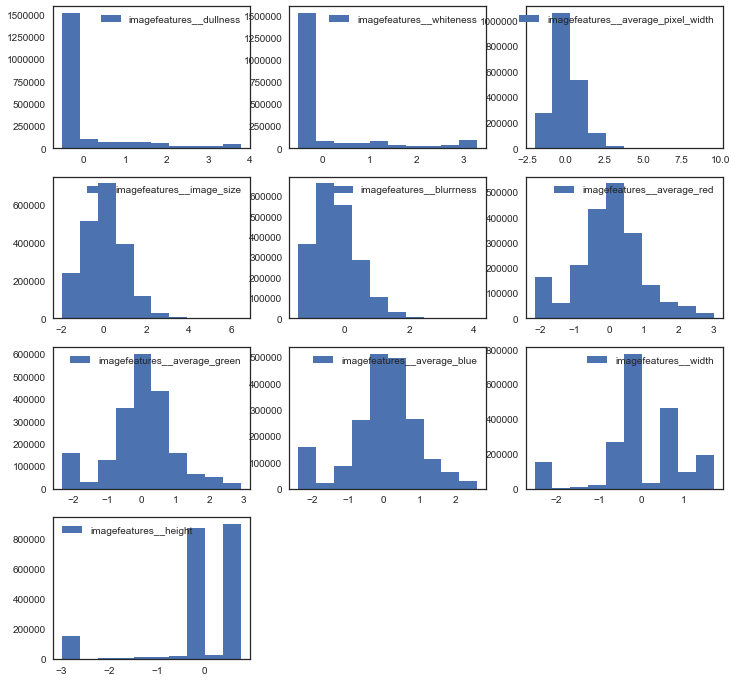

(2011862, 10)
Memory usage of dataframe is 115.12 MB
Memory usage after optimization is: 92.10 MB
Decreased by 20.0%
(2011862, 54)
395.24419021606445  MB


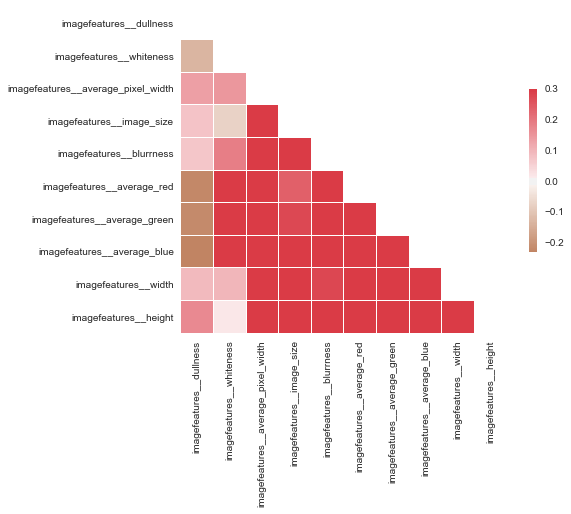

In [36]:
# Image Features
df = loadfeather('../features/train/imagefeatures_train.feather', '../features/test/imagefeatures_test.feather')
df = scale_minmax(df)
df = scale_standard(df)
df['imagefeatures__blurrness'] = np.log1p(df['imagefeatures__blurrness'])
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

imagenet_Resnet50_top1    1737109
imagenet_Resnet50_top2    1790338
imagenet_Resnet50_top3    1793828
dtype: int64


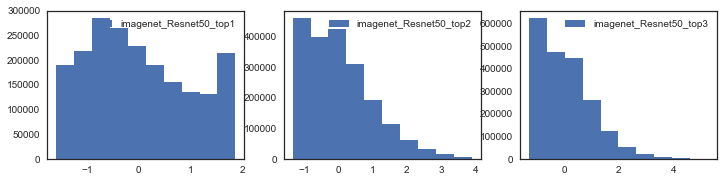

(2011862, 3)
Memory usage of dataframe is 61.40 MB
Memory usage after optimization is: 38.37 MB
Decreased by 37.5%
(2011862, 57)
418.268123626709  MB
imagenet_IndeptionV3_top1     579634
imagenet_IndeptionV3_top2    1725460
imagenet_IndeptionV3_top3    1728988
dtype: int64


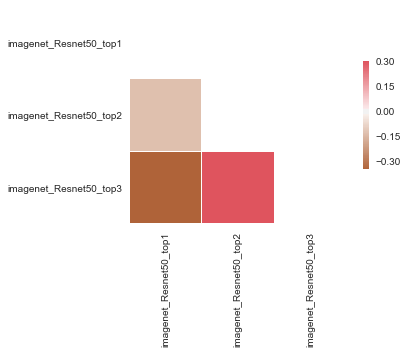

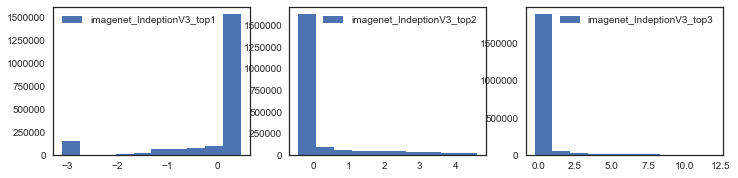

(2011862, 3)
Memory usage of dataframe is 61.40 MB
Memory usage after optimization is: 38.37 MB
Decreased by 37.5%
(2011862, 60)
441.2920570373535  MB
imagenet_Xception_top1    1085618
imagenet_Xception_top2    1823811
imagenet_Xception_top3    1828911
dtype: int64


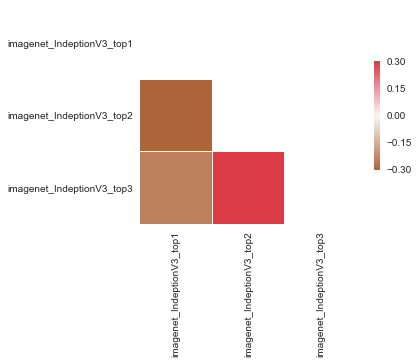

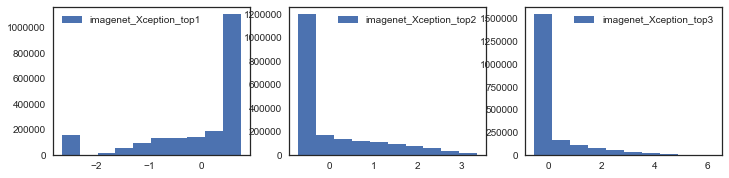

(2011862, 3)
Memory usage of dataframe is 61.40 MB
Memory usage after optimization is: 38.37 MB
Decreased by 37.5%
(2011862, 63)
464.31599044799805  MB


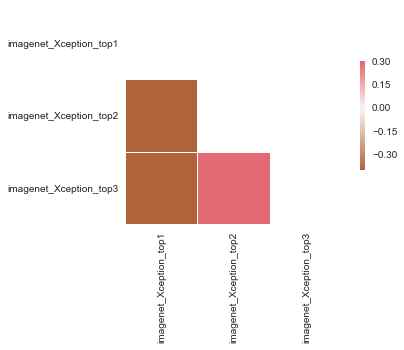

In [37]:
# imagenet
# Resnet50
df = loadfeather('../features/train/imagenet_Resnet50_train.feather', '../features/test/imagenet_Resnet50_test_debug.feather')
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Inception V3
df = loadfeather('../features/train/imagenet_IndeptionV3_train.feather', '../features/test/imagenet_IndeptionV3_test_debug.feather')
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Xception
df = loadfeather('../features/train/imagenet_Xception_train.feather', '../features/test/imagenet_Xception_test_debug.feather')
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

In [38]:
# Create fulldata

train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_full.feather')
test.to_feather('../features/featured/test_full.feather')

del train, test; gc.collect()
categorical


(1503424, 63)
(508438, 63)


['region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'user_type',
 'param_123']

In [39]:
# Create Reduced data
'''
train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

res = get_smalldiff(train, test, userate=0.6)
train = train[res]
test = test[res]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_reduced.feather')
test.to_feather('../features/featured/test_reduced.feather')

categorical_ex1 = [col for col in train.columns if col in categorical]
del train, test; gc.collect()
categorical_ex1
'''


"\ntrain = dfmaster[:lentrain]\ntest = dfmaster[lentrain: lentrain+lentest]\n\nres = get_smalldiff(train, test, userate=0.6)\ntrain = train[res]\ntest = test[res]\n\nprint(train.shape)\nprint(test.shape)\n\ntrain.to_feather('../features/featured/train_reduced.feather')\ntest.to_feather('../features/featured/test_reduced.feather')\n\ncategorical_ex1 = [col for col in train.columns if col in categorical]\ndel train, test; gc.collect()\ncategorical_ex1\n"

In [40]:
# Create Reduced data
'''
train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

res = get_smalldiff(train, test, userate=0.3)
train = train[res]
test = test[res]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_reduced_more.feather')
test.to_feather('../features/featured/test_reduced_more.feather')

categorical_ex2 = [col for col in train.columns if col in categorical]
del train, test; gc.collect()
categorical_ex2
'''


"\ntrain = dfmaster[:lentrain]\ntest = dfmaster[lentrain: lentrain+lentest]\n\nres = get_smalldiff(train, test, userate=0.3)\ntrain = train[res]\ntest = test[res]\n\nprint(train.shape)\nprint(test.shape)\n\ntrain.to_feather('../features/featured/train_reduced_more.feather')\ntest.to_feather('../features/featured/test_reduced_more.feather')\n\ncategorical_ex2 = [col for col in train.columns if col in categorical]\ndel train, test; gc.collect()\ncategorical_ex2\n"

In [41]:
dfmaster.head()

,price,item_seq_number,region,city,parent_category_name,category_name,param_1,user_type,param_123,tfidf_td_counttp_ridge,...,imagefeatures__height,imagenet_Resnet50_top1,imagenet_Resnet50_top2,imagenet_Resnet50_top3,imagenet_IndeptionV3_top1,imagenet_IndeptionV3_top2,imagenet_IndeptionV3_top3,imagenet_Xception_top1,imagenet_Xception_top2,imagenet_Xception_top3
0,-0.677024,-1.297003,21,472,6,43,252,1,1013,-0.251175,...,0.758586,-1.593788,-1.340257,-1.277058,-3.098809,-0.434866,-0.254238,-2.640898,-0.722033,-0.536383
1,0.053957,-0.300644,19,1340,4,23,123,1,309,0.383229,...,0.758586,-1.168998,-0.284857,0.356289,0.468036,-0.434866,-0.254238,-0.113284,0.965497,0.314698
2,0.158325,-0.664682,18,1315,2,3,85,1,104,0.398068,...,-0.177207,0.385052,1.059754,1.995884,0.466027,-0.429679,-0.252410,0.736486,-0.718790,-0.534728
3,-0.058563,1.098346,23,973,6,43,38,0,42,1.555028,...,-0.177207,-0.649074,0.338398,0.870230,0.468036,-0.434866,-0.254238,0.522710,-0.200076,-0.536383
4,0.993674,-1.145914,6,326,8,1,281,1,2893,1.569154,...,-0.177207,0.426342,-0.084749,0.381963,0.330671,-0.047079,-0.251051,-1.615118,1.551687,2.746046
